In [12]:
pip install librosa scikit-learn python_speech_features sounddevice tqdm

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc
from tqdm import tqdm

In [14]:
import librosa
import numpy as np

# Function to extract MFCC features
def extract_mfcc_features(audio, sr=16000, num_cepstral=13, frame_length=0.02, frame_stride=0.02,
                           num_filters=32, fft_length=320, preemphasis_coeff=0.98):
    # Apply pre-emphasis
    audio = np.append(audio[0], audio[1:] - preemphasis_coeff * audio[:-1])

    # Compute the short-time Fourier transform (STFT)
    hop_length = int(frame_stride * sr)
    n_fft = fft_length
    window = "hann"  # You can choose a different window function if needed
    stft_result = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft, window=window)

    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(stft_result)**2, sr=sr, n_mels=num_filters)

    # Logarithm of the mel spectrogram
    log_mel_energy = np.log(mel_spectrogram + 1e-9)

    # Extract MFCC features using DCT
    mfcc_features = librosa.feature.mfcc(S=log_mel_energy, n_mfcc=num_cepstral)

    # Apply mean and variance normalization across time
    mfcc_features = librosa.util.normalize(mfcc_features, norm=2, axis=0, fill=True)

    return mfcc_features

In [15]:
from tqdm import tqdm
import librosa
def preprocess_data(data_dir):
    data = []
    labels = []
    features = []

    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr = 16000)

            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })
           
            #audio = butter_bandpass_filter(audio)
            mfcc_features = extract_mfcc_features(audio)
            features.append(mfcc_features)
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)
    classes = set(labels)

     #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return features ,classes ,(X_train, y_train), (X_test, y_test)
# Example usage
data_dir = "/Users/doctorranjan/Desktop/yp/hackathon/Dataset"

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

def train_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Reshape((X_train.shape[1], X_train.shape[2], 1)),
        layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(X_train, encoded_labels_train, epochs=100, batch_size=32, validation_data=(X_test, encoded_labels_test))

    model.save("custom_model.keras")

    return model, encoder

# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir)
num_classes = len(classes)

# Print shapes of MFCC features and model input
print("MFCC Features Shape:", features.shape)
print("Model Input Shape:", X_train.shape[1:])

# Train the model
trained_model, label_encoder = train_model(X_train, y_train, num_classes, X_test, y_test)

Processing door_close: 100%|███████████████| 3503/3503 [00:25<00:00, 136.14it/s]


MFCC Features Shape: (12674, 13, 51)
Model Input Shape: (13, 51)


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_4. Consider increasing the input size. Received input shape [None, 1, 11, 16] which would produce output shape with a zero or negative value in a dimension.

80/80 [==============================] - 1s 5ms/step
Accuracy: 93.73%
Precision: 93.79%
Recall: 93.73%
F1 Score: 93.69%


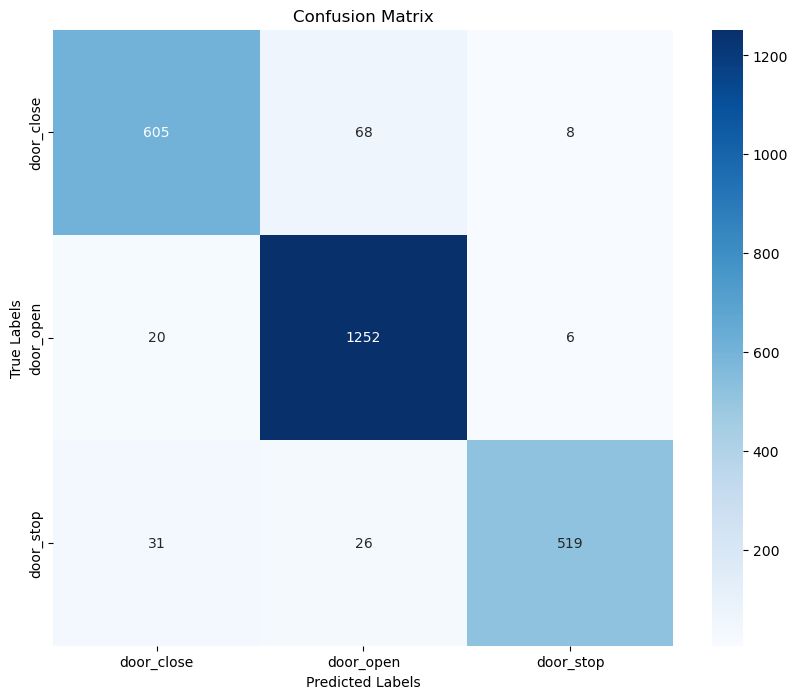

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and print multiple evaluation metrics
def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions on test set
    y_pred = model.predict(X_test)

    # Convert predictions to class labels
    y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have the trained_model, X_test, y_test, and label_encoder
evaluate_model(trained_model, X_test, y_test, label_encoder)


In [11]:
print(X_test.shape)

(2535, 13, 51)
